In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import os
import pandas as pd

from scipy import signal
from scipy.signal import cheby2, freqz, filtfilt
from scipy import stats

In [3]:
#Functions

#Nan interpolation function
def Nan_interpolation(input_sig):
    nan_indices = np.isnan(input_sig)
    non_nan_indices = np.arange(len(input_sig))[~nan_indices]
    for indx in np.where(nan_indices)[0]:
        input_sig[nan_indices] = np.interp(indx, non_nan_indices, input_sig[non_nan_indices])
    
    return input_sig

def Notch_Detection(input_sig, peaks_indx, valleys_indx):
    dnotch_indx = np.empty((0,), dtype = int)

    # Notch detection(peak이후 valley 이전, 2차 미분 후 0 이상 최대 피크값)
    BPF_sig_fder = np.gradient(input_sig)
    window_size = 100
    BPF_sig_fder = np.convolve(BPF_sig_fder, np.ones(window_size)/window_size, mode='same')

    BPF_sig_sder = np.gradient(BPF_sig_fder)
    window_size = 100
    BPF_sig_sder = np.convolve(BPF_sig_sder, np.ones(window_size)/window_size, mode='same')

    for i in range(valleys_indx.shape[0]-1):
        temp_indx_array,_ = signal.find_peaks(BPF_sig_sder[peaks_indx[i+1]:valleys_indx[i+1]], height=0)

        if len(temp_indx_array) == 0: # Dicrotic Notch가 보이지 않는 경우
            temp_indx = -1
        else:
            temp_indx = temp_indx_array[0] + peaks_indx[i+1]

        dnotch_indx = np.append(dnotch_indx, temp_indx)
    
    return dnotch_indx

def Valley_Window(input_sig, valleys_indx):
    n = len(input_sig)
    Win_indx = np.empty((0,2), dtype = int)
    for i in range(len(valleys_indx)//5-1):
        seg_s = valleys_indx[5*i]
        seg_e = valleys_indx[5*i+5]
        Win_indx = np.insert(Win_indx, Win_indx.shape[0], [seg_s, seg_e], axis = 0)
    return Win_indx

def Auto_Correlation_Filter(input_sig, win_indx):
    n = len(input_sig)
    corrupted_indx = np.empty((0,), dtype = int)
    for i in range(win_indx.shape[0]):
        seg_s = win_indx[i,0]
        seg_e = win_indx[i,1]
        auto_correlation = np.correlate(input_sig[seg_s:seg_e], input_sig[seg_s:seg_e], mode = 'full')
        auto_correlation = auto_correlation/np.max(auto_correlation)
        ac_s_peaks, _ = signal.find_peaks(auto_correlation, height=0.7)
        if len(ac_s_peaks) < 3:
            corrupted_indx = np.append(corrupted_indx, i)
    
    out_win_indx = np.delete(win_indx, corrupted_indx, axis = 0)
    return out_win_indx, corrupted_indx

# Amplitude
def AmAB_feat(input_sig, sig_indx, win_num):
    
    ft_amab = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_amab_temp = np.empty((0,))
        for k in range(win_num):
            ft_amab_temp = np.append(ft_amab_temp, input_sig[sig_indx[i, 3*k+1]]-input_sig[sig_indx[i, 3*k]])
        ft_amab = np.insert(ft_amab, ft_amab.shape[0], ft_amab_temp, axis=0)
        
    return ft_amab

def AmBC_feat(input_sig, sig_indx, win_num):
    
    ft_ambc = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_ambc_temp = np.empty((0,))
        for k in range(win_num):
            ft_ambc_temp = np.append(ft_ambc_temp, input_sig[sig_indx[i, 3*k+1]]-input_sig[sig_indx[i, 3*k+2]])
        ft_ambc = np.insert(ft_ambc, ft_ambc.shape[0], ft_ambc_temp, axis=0)
        
    return ft_ambc

def AmAC_feat(input_sig, sig_indx, win_num):
    
    ft_amac = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_amac_temp = np.empty((0,))
        for k in range(win_num):
            ft_amac_temp = np.append(ft_amac_temp, input_sig[sig_indx[i, 3*k+2]]-input_sig[sig_indx[i, 3*k]])
        ft_amac = np.insert(ft_amac, ft_amac.shape[0], ft_amac_temp, axis=0)
        
    return ft_amac


def RtAC_AB_feat(input_sig, sig_indx, win_num):
    
    ft_rtac_ab = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_rtac_ab_temp = np.empty((0,))
        for k in range(win_num):
            ft_rtac_ab_temp = np.append(ft_rtac_ab_temp, (input_sig[sig_indx[i, 3*k+2]]-input_sig[sig_indx[i, 3*k]])/
                                        (input_sig[sig_indx[i, 3*k+1]]-input_sig[sig_indx[i, 3*k]]))
        ft_rtac_ab = np.insert(ft_rtac_ab, ft_rtac_ab.shape[0], ft_rtac_ab_temp, axis=0)
        
    return ft_rtac_ab

def RtAC_BC_feat(input_sig, sig_indx, win_num):
    
    ft_rtac_bc = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_rtac_bc_temp = np.empty((0,))
        for k in range(win_num):
            ft_rtac_bc_temp = np.append(ft_rtac_bc_temp, (input_sig[sig_indx[i, 3*k+2]]-input_sig[sig_indx[i, 3*k]])/
                                        (input_sig[sig_indx[i, 3*k+1]]-input_sig[sig_indx[i, 3*k+2]]))
        ft_rtac_bc = np.insert(ft_rtac_bc, ft_rtac_bc.shape[0], ft_rtac_bc_temp, axis=0)
        
    return ft_rtac_bc

# TmBB Peak to Peak distance
def TmBB_feat(sig_indx, win_num):
    
    ft_tmbb = np.empty((0,win_num-1))

    for i in range(sig_indx.shape[0]):
        ft_tmbb_temp = np.empty((0,))
        for k in range(win_num-1):
            ft_tmbb_temp = np.append(ft_tmbb_temp, sig_indx[i, (k+1)*3+1]-sig_indx[i, k*3+1])
        ft_tmbb = np.insert(ft_tmbb, ft_tmbb.shape[0], ft_tmbb_temp, axis=0)
    
    return ft_tmbb

def TmAC_feat(sig_indx, win_num):
    
    ft_tmac = np.empty((0,win_num))

    for i in range(sig_indx.shape[0]):
        ft_tmac_temp = np.empty((0,))
        for k in range(win_num):
            ft_tmac_temp = np.append(ft_tmac_temp, sig_indx[i, 3*k+2]-sig_indx[i, 3*k])
        ft_tmac = np.insert(ft_tmac, ft_tmac.shape[0], ft_tmac_temp, axis=0)
    
    return ft_tmac

# TmBB Peak to Peak distance
def TmCA_feat(sig_indx, win_num):
    
    ft_tmca = np.empty((0,win_num))

    for i in range(sig_indx.shape[0]):
        ft_tmca_temp = np.empty((0,))
        for k in range(win_num):
            ft_tmca_temp = np.append(ft_tmca_temp, sig_indx[i, 3*(k+1)]-sig_indx[i, 3*(k+1)-1])
        ft_tmca = np.insert(ft_tmca, ft_tmca.shape[0], ft_tmca_temp, axis=0)
    
    return ft_tmca

def RSD_feat(sig_indx, win_num):
    
    ft_RSD = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_RSD_temp = np.empty((0,))
        for k in range(win_num):
            ft_RSD_temp = np.append(ft_RSD_temp, (sig_indx[i, 3*k+2]-sig_indx[i, 3*k]+1)/(sig_indx[i, 3*(k+1)]-sig_indx[i, 3*k+2]+1))
        ft_RSD = np.insert(ft_RSD, ft_RSD.shape[0], ft_RSD_temp, axis=0)
    
    return ft_RSD

def RtArea_feat(input_sig, sig_indx, win_num): # 독창적인 방법
    ft_RtArea = np.empty((0,win_num))
    
    for i in range(sig_indx.shape[0]):
        ft_RtArea_temp = np.empty((0,))
        for k in range(win_num):
            com_r = (input_sig[sig_indx[i, 3*(k+1)]] - input_sig[sig_indx[i,3*k]])/(sig_indx[i,3*(k+1)]-sig_indx[i,3*k])

            sum_ac = np.sum(input_sig[sig_indx[i,3*k]:sig_indx[i,3*k+2]+1]-input_sig[sig_indx[i,3*k]]) - (com_r*(sig_indx[i,3*k+2]-sig_indx[i,3*k])**2)/2
            sum_ca = np.sum(input_sig[sig_indx[i,3*k+2]:sig_indx[i,3*(k+1)]+1]-input_sig[sig_indx[i,3*k]]) - (com_r*(sig_indx[i,3*(k+1)]-sig_indx[i,3*k+2])**2)/2
            
            ft_RtArea_temp = np.append(ft_RtArea_temp, sum_ca/sum_ac)
        ft_RtArea = np.insert(ft_RtArea, ft_RtArea.shape[0], ft_RtArea_temp, axis=0)
    return ft_RtArea

In [9]:
# Preprocessing: fs 조절 필요
# 한 개의 데이터에 몇 개의 펄스가 들어가야 할지 고민
# sampling frequency -> 2000Hz신호를 바탕으로 처리
# Normalization 여부 고민
# 음주여부 3분류,  one hot code로 변경해서 코딩
# Correlation 분석까지.

# 전체 데이터 부르기. 나중에 한꺼번에 전처리 할 때 for 문 응용
folder_path = input("Type dataset folder path: ")
win_num = int(input("Type pluse num of characteristics: "))
file_list = os.listdir(folder_path)

for filename in file_list:
    if filename.endswith('1_1_1.npy'):  # Check if the file is an .npz file
        file_path = os.path.join(folder_path, filename)  # Get the full path of the file
        ppg_sig = np.load(file_path)  # Load data from the .npz file
        # 1, 2, 3 이 음주의 어떤 상태인지 파악
        print("Data load: ", filename)

        #Nan interpolation
        ppg_nan_interpolated_sig = Nan_interpolation(ppg_sig)

        # Applying moving average filter
        window_size = 100  
        ppg_BPF_sig = np.convolve(ppg_nan_interpolated_sig, np.ones(window_size)/window_size, mode='same')

        # Peak & Valley detection 2
        peaks_indx, _ = signal.find_peaks(ppg_BPF_sig, distance = 1000)
        valleys_indx = np.array([], dtype = np.int64)
        for i in range(len(peaks_indx)-1):
            v_indx = np.argmin(ppg_BPF_sig[peaks_indx[i]: peaks_indx[i + 1]]) + peaks_indx[i]
            valleys_indx = np.append(valleys_indx, v_indx)

        # Dicrotic Nothc in signal detection
        dnotch_indx = Notch_Detection(ppg_BPF_sig, peaks_indx, valleys_indx)

        # Windowing according to last pulse(valley)
        win_indx = Valley_Window(ppg_BPF_sig, valleys_indx)

        # Auto-Correlation 방식 사용
        ACF_win_indx, corrupted_win_indx = Auto_Correlation_Filter(ppg_BPF_sig, win_indx) #모든 연산, 필터링은 인덱스를 기준으로

        # Notch가 없는 윈도우 제거 - 실험 결과 Auto-Correlation 방식으로 제거 됨
        for i in range(dnotch_indx.shape[0]):
            if dnotch_indx[i] == -1:
                for k in range(win_indx.shape[0]):
                    if dnotch_indx[i] > win_indx[k, 0] and dnotch_indx[i] < win_indx[k, 1]:
                        corrupted_win_indx = np.append(corrupted_win_indx, k)
                        continue

        corrupted_win_indx = np.unique(corrupted_win_indx)

        ppg_indx_c = np.empty((0, 3*win_num+1), dtype = int) # 윈도우 시작점 - 피크 노치 벨리 x5
        
        for i in range(valleys_indx.shape[0]//win_num-1):
            temp = []
            for k in range(win_num):
                temp.append(valleys_indx[win_num*i+k])
                temp.append(peaks_indx[win_num*i+k+1])
                temp.append(dnotch_indx[win_num*i+k])
            temp.append(valleys_indx[win_num*i+win_num])
            ppg_indx_c = np.insert(ppg_indx_c, ppg_indx_c.shape[0], temp, axis=0)

        ppg_indx = np.delete(ppg_indx_c, corrupted_win_indx, axis=0)
        
        #Min Max Normalization signal 윈도우별로 normalization
        ppg_norm = ppg_BPF_sig
        
        break
        
        for i in range(ppg_indx.shape[0]):
            ppg_norm_temp = np.empty((0,), dtype = float)
            
            ppg_sig_temp = ppg_BPF_sig[ppg_indx[i,0]:ppg_indx[i,-1]]
            mean_temp = np.mean(ppg_sig_temp)
            std_temp = np.std(ppg_sig_temp)
            ppg_norm_temp = (ppg_sig_temp - mean_temp) / std_temp
            ppg_norm[ppg_indx[i,0]:ppg_indx[i,-1]] = ppg_norm_temp
            
        # (1) Feature Extraction - Standard Deviation of Peak to peak Amplitude
        ft_amab = AmAB_feat(ppg_norm, ppg_indx, win_num)
        ft_ambc = AmBC_feat(ppg_norm, ppg_indx, win_num)
        ft_amac = AmAC_feat(ppg_norm, ppg_indx, win_num)
        ft_RtAC_AB = RtAC_AB_feat(ppg_norm, ppg_indx, win_num)
        ft_RtAC_BC = RtAC_BC_feat(ppg_norm, ppg_indx, win_num)
        ft_tmbb = TmBB_feat(ppg_indx, win_num)
        ft_tmac = TmAC_feat(ppg_indx, win_num)
        ft_tmca = TmCA_feat(ppg_indx, win_num)
        ft_RSD = RSD_feat(ppg_indx, win_num)
        ft_RtArea = RtArea_feat(ppg_norm, ppg_indx, win_num)

        # all feature array -> Data, Labeling
        ft_length = (win_num-1) + 9*win_num
        ft_array = np.empty((0, ft_length))
        
        for i in range(ppg_indx.shape[0]):
            ft_array = np.concatenate((ft_amab, ft_ambc, ft_amac, ft_RtAC_AB, ft_RtAC_BC, ft_tmbb,ft_tmac, ft_tmca, ft_RSD, ft_RtArea), axis=1)
        
        break

Type dataset folder path:  C:\Users\jorgo\내 드라이브\Research\ppg_alcohol\Dataset\npy_original_files
Type pluse num of characteristics:  2


Data load:  1_1_1.npy


In [ ]:
Type dataset folder path:  C:\Users\jorgo\내 드라이브\Research\ppg_alcohol\Dataset\npy_original_files
Type pluse num of characteristics:  2

In [115]:
print(x_ticks_pos, x_ticks)

[758000 760000] [379 380]


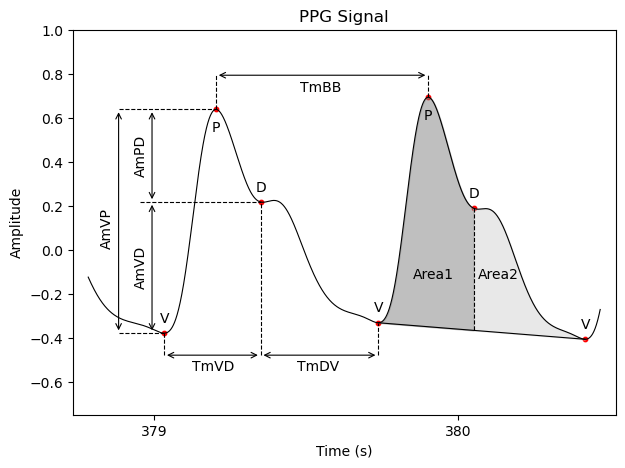

In [184]:
fig2, ax2 = plt.subplots(figsize=(7,5))
onset_indx = 0
i=240

seg_s = ppg_indx[i+onset_indx, 0]-500
seg_e = ppg_indx[i+onset_indx, -1]+100
x_ticks = np.empty((0,), dtype = np.int32)
x_ticks_pos = np.empty((0,), dtype = np.int32)
x_ticks_temp = np.array(range(seg_s,seg_e))//2000
f_num = x_ticks_temp[0]
for i in range(len(x_ticks_temp)):
    if x_ticks_temp[i] != f_num:
        x_ticks = np.append(x_ticks, x_ticks_temp[i])
        x_ticks_pos = np.append(x_ticks_pos, seg_s+i)
        f_num = x_ticks_temp[i]


temp_peaks = [k for k in peaks_indx if k>seg_s and k<seg_e]
temp_valleys = [m for m in valleys_indx if m>seg_s and m<seg_e]
temp_notches = [l+50 for l in dnotch_indx if l>seg_s and l<seg_e]
ax2.scatter(temp_valleys, ppg_norm[temp_valleys], c='r', s = 10, marker='o')
ax2.scatter(temp_peaks, ppg_norm[temp_peaks], c ='r', s = 10, marker='o')
ax2.scatter(temp_notches, ppg_norm[temp_notches], c='r', s=10, marker='o')
#ax2.xaxis.set_major_formatter(ticker.FuncFormatter(sec_out(x)))
ax2.plot(x_range, ppg_norm[seg_s:seg_e], c='k', linewidth = 0.8)
ax2.set_title("PPG Signal")
ax2.set_xlim(seg_s-100, seg_e+100)
ax2.set_ylim(-0.75, 1)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_xticks(x_ticks_pos, #라벨 위치
               x_ticks) # 라벨

# 좌표
x_v1, y_v1 = temp_valleys[0], ppg_norm[temp_valleys[0]]
x_v2, y_v2 = temp_valleys[1], ppg_norm[temp_valleys[1]]
x_v3, y_v3 = temp_valleys[2], ppg_norm[temp_valleys[2]]

x_p1, y_p1 = temp_peaks[0], ppg_norm[temp_peaks[0]]
x_p2, y_p2 = temp_peaks[1], ppg_norm[temp_peaks[1]]

x_d1, y_d1 = temp_notches[0], ppg_norm[temp_notches[0]]
x_d2, y_d2 = temp_notches[1], ppg_norm[temp_notches[1]]

# V 표시
ax2.text(x = x_v1-30, y = y_v1+0.05, s='V', fontsize=10, color='k')
ax2.text(x = x_v2-30, y = y_v2+0.05, s='V', fontsize=10, color='k')
ax2.text(x = x_v3-30, y = y_v3+0.05, s='V', fontsize=10, color='k')

# P 표시
ax2.text(x = x_p1-30, y = y_p1-0.1, s='P', fontsize=10, color='k')
ax2.text(x = x_p2-30, y = y_p2-0.1, s='P', fontsize=10, color='k')

# D 표시
ax2.text(x = x_d1-30, y = y_d1+0.05, s='D', fontsize=10, color='k')
ax2.text(x = x_d2-30, y = y_d2+0.05, s='D', fontsize=10, color='k')

# TmVD
ax2.annotate(text='', xy=(x_v1,y_v1-0.1), xytext=(x_d1, y_v1-0.1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.plot([x_d1,x_d1],[y_v1-0.1, y_d1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.plot([x_v1,x_v1],[y_v1-0.1, y_v1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.text(x = x_p1-160, y = y_v1-0.17, s="TmVD", fontsize=10, color='k')

# TmDV
plt.annotate(text='', xy=(x_d1,y_v1-0.1), xytext=(x_v2, y_v1-0.1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.plot([x_v2,x_v2],[y_v1-0.1, y_v2], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.text(x = x_d1+240, y = y_v1-0.17, s="TmDV", fontsize=10, color='k')

# TmBB
plt.annotate(text='', xy=(x_p1,y_p2+0.1), xytext=(x_p2,y_p2+0.1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.plot([x_p1,x_p1],[y_p1, y_p2+0.1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.plot([x_p2,x_p2],[y_p2, y_p2+0.1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.text(x = x_p1+550, y = y_p1 + 0.08, s="TmBB", fontsize=10, color='k')

# AmVP
plt.annotate(text='', xy=(x_v1-300,y_v1), xytext=(x_v1-300,y_p1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.plot([x_v1-300, x_p1],[y_p1, y_p1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.plot([x_v1-300, x_v1],[y_v1, y_v1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.text(x = x_v1-420, y = y_v2+0.35, s="AmVP", fontsize=10, rotation = 'vertical', color='k')

# AmPD
ax2.annotate(text='', xy=(x_v1-80,y_d1), xytext=(x_v1-80,y_p1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.plot([x_v1-160, x_d1],[y_d1, y_d1], color='black', linewidth = 0.8,linestyle='--', label='D')
ax2.text(x = x_v1-200, y = y_v2+0.68, s="AmPD", fontsize=10, rotation = 'vertical', color='k')

# AmVD
ax2.annotate(text='', xy=(x_v1-80,y_v1), xytext=(x_v1-80,y_d1), arrowprops=dict(arrowstyle='<->', linewidth = 0.8))
ax2.text(x = x_v1-200, y = y_v2+0.17, s="AmVD", fontsize=10, rotation = 'vertical', color='k')

# # RtArea
ax2.plot([x_v2, x_v3],[y_v2, y_v3], color='black', linewidth = 0.8,linestyle='-', label='RtArea')
ax2.plot([x_d2, x_d2],[y_d2, (y_v2+y_v3)/2], color='black', linewidth = 0.8,linestyle='--', label='RtArea')
ax2.text(x = x_p2-100, y = y_v2+0.2, s="Area1", fontsize=10, color='k')
ax2.text(x = x_d2+30, y = y_v2+0.2, s="Area2", fontsize=10, color='k')

# Area 1
x_Rt_Area_1 = np.array((range(x_v2, x_d2)))
y_Rt_Area_1 = (y_v3-y_v2)/(x_v3-x_v2)*(x_Rt_Area_1 - x_v2) + y_v2

ax2.fill_between(x_Rt_Area_1, ppg_norm[x_v2:x_d2], y_Rt_Area_1[:], color='gray', alpha=0.5)

x_Rt_Area_2 = np.array((range(x_d2, x_v3)))
y_Rt_Area_2 = (y_v3-y_v2)/(x_v3-x_v2)*(x_Rt_Area_2 - x_v2) + y_v2
ax2.fill_between(x_Rt_Area_2, ppg_norm[x_d2:x_v3], y_Rt_Area_2, color='lightgray', alpha=0.5)

In [185]:
save_material_path = input("Type save folder path for the picture: ")
fig2.savefig(save_material_path+'/PPG_signal_preprocessing.png')

Type save folder path for the picture:  C:\Users\jorgo\내 드라이브\Research\ppg_alcohol\Paper\Materials


Text(0.5, 1.0, '')

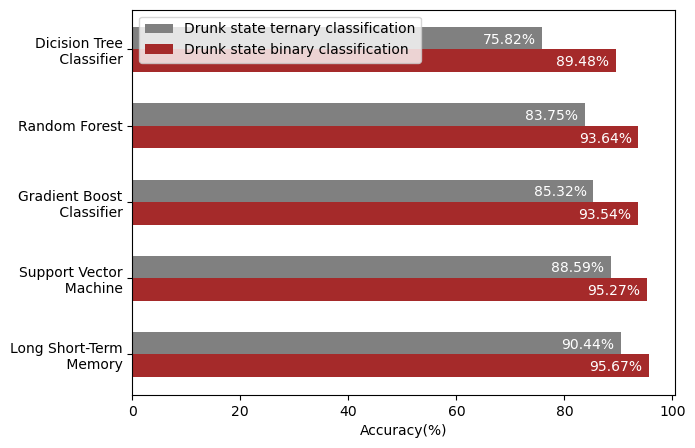

In [23]:
##### Sample data
label = ['Long Short-Term\n Memory', 'Support Vector\n  Machine', 'Gradient Boost\n Classifier', 'Random Forest', 'Dicision Tree\n Classifier' ]  
x_pos = np.arange(5)

# Y-values (heights of sticks)
height_1 = [90.44, 88.59, 85.32, 83.75, 75.82]  # X-coordinates
height_2 = [95.67, 95.27, 93.54, 93.64, 89.48]  # Binary classification

#colors_b = ['black', 'dimgrey','grey','darkgray', 'silver']
colors_b = ['grey','grey','grey','grey','grey']
#colors_r = ['darkred', 'brown', 'firebrick','indianred','lightcoral']
colors_r = ['brown', 'brown','brown','brown','brown']

res_df = pd.DataFrame({'Binary' : height_1, 'Trit' : height_2, 'index' : label})

bar_width = 0.3

# Create a new figure
plt.figure(figsize=(7, 5))

# Plot vertical sticks
b1 = plt.barh(x_pos+ bar_width-0.01, height_1, height=bar_width, color = colors_b, label = "Drunk state ternary classification")
b2 = plt.barh(x_pos , height_2, height=bar_width, color = colors_r, label = "Drunk state binary classification")
plt.legend(loc = "upper left")

plt.text(x=height_2[-1]-11, y=x_pos[-1]-0.07, s=str(height_2[-1])+"%", fontsize=10, color='white')
plt.text(x=height_2[-2]-11, y=x_pos[-2]-0.07, s=str(height_2[-2])+"%", fontsize=10, color='white')
plt.text(x=height_2[-3]-11, y=x_pos[-3]-0.07, s=str(height_2[-3])+"%", fontsize=10, color='white')
plt.text(x=height_2[-4]-11, y=x_pos[-4]-0.07, s=str(height_2[-4])+"%", fontsize=10, color='white')
plt.text(x=height_2[-5]-11, y=x_pos[-5]-0.07, s=str(height_2[-5])+"%", fontsize=10, color='white')

plt.text(x=height_1[-1]-11, y=x_pos[-1]+0.23, s=str(height_1[-1])+"%", fontsize=10, color='white')
plt.text(x=height_1[-2]-11, y=x_pos[-2]+0.23, s=str(height_1[-2])+"%", fontsize=10, color='white')
plt.text(x=height_1[-3]-11, y=x_pos[-3]+0.23, s=str(height_1[-3])+"%", fontsize=10, color='white')
plt.text(x=height_1[-4]-11, y=x_pos[-4]+0.23, s=str(height_1[-4])+"%", fontsize=10, color='white')
plt.text(x=height_1[-5]-11, y=x_pos[-5]+0.23, s=str(height_1[-5])+"%", fontsize=10, color='white')

plt.yticks(np.arange(bar_width/2, 5 + bar_width/2, 1), label)

# Add labels and title
plt.xlabel('Accuracy(%)')
plt.title('')

# save_material_path = input("Type save folder path for the picture: ")
# plt.savefig(save_material_path+'/Result.png')